952


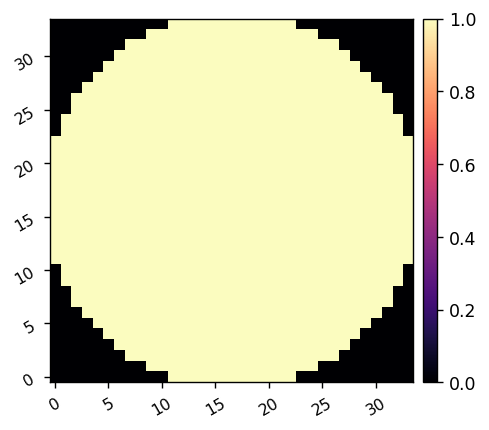

In [54]:


import numpy as np
import astropy.units as u
from astropy.io import fits

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.props as props
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.optimize import minimize


Nact = 34
wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm
lyot_stop_diam = 8.6*u.mm
scc_sep = 5.5*u.mm

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))

print(Nacts)
imshow1(dm_mask)

In [23]:
import scoobpsf.props as props

# Establish the forward model and the relavent EFC parameters for simulation.

Oversampling > 2x suggested for reliable results in Fresnel propagation.


470


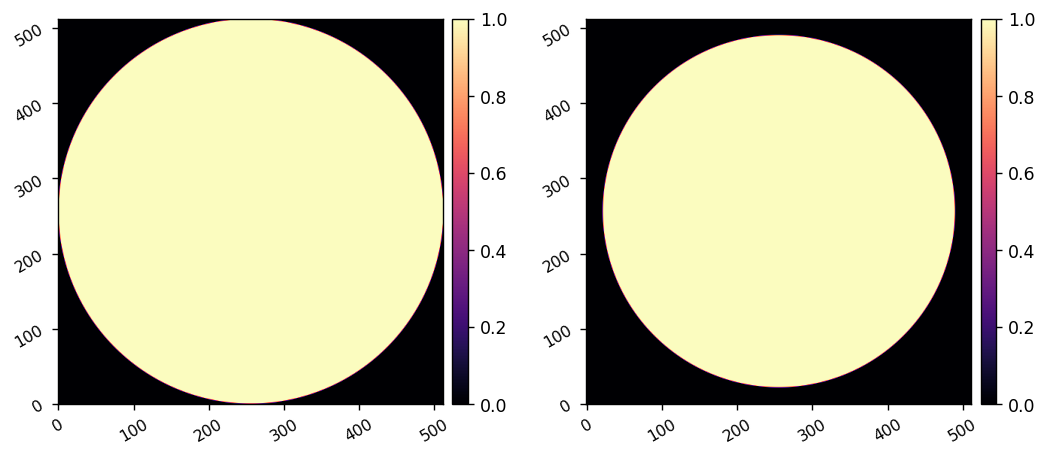

16.340425531914892
588


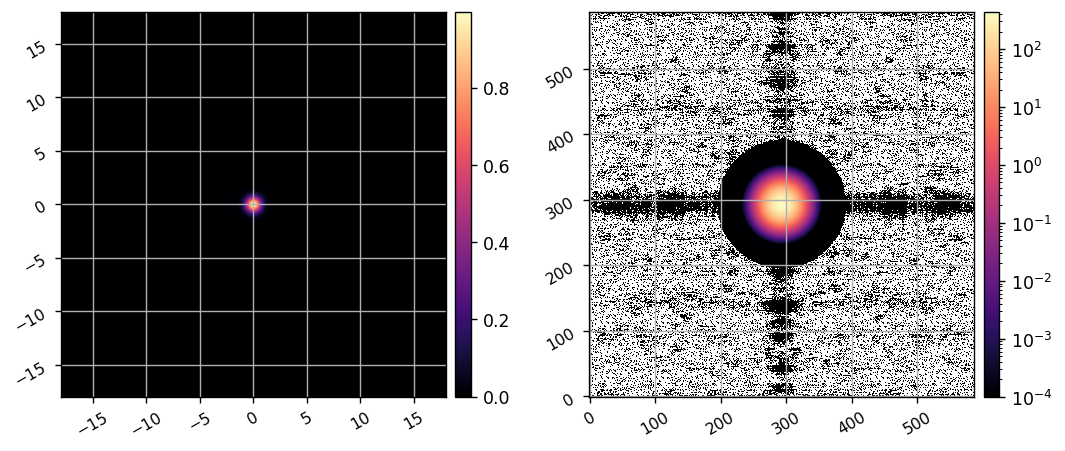

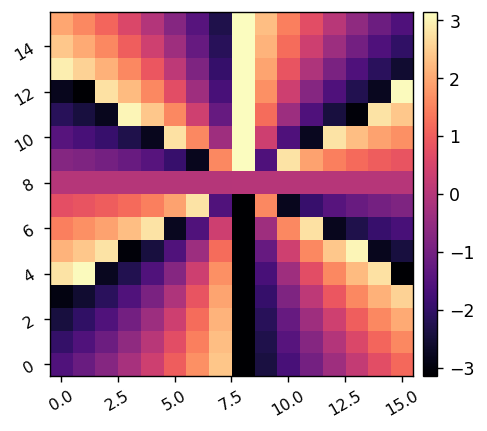

In [75]:
npix = 512
oversample = 32
N = int(npix*oversample)

nlyot = int(np.ceil(lyot_stop_diam/pupil_diam * npix))
if nlyot%2==1:
    nlyot += 1
print(nlyot)

import poppy
pwf = poppy.FresnelWavefront(beam_radius=pupil_diam/2, npix=npix, oversample=1) # pupil wavefront
APERTURE = poppy.CircularAperture(radius=pupil_diam/2).get_transmission(pwf)
LYOT = poppy.CircularAperture(radius=lyot_stop_diam/2).get_transmission(pwf)
imshow2(APERTURE, LYOT)

act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

# Nsurf = int(2 ** np.ceil(np.log2(inf_sampling*Nact - 1)))  # next power of 2
# print(Nsurf)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

fourier_inf_fun = xp.fft.fft2(inf_fun)
imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
    
# Influence function frequncy sampling
fx = xp.fft.fftfreq(Nsurf)
fy = xp.fft.fftfreq(Nsurf)

# forward DM model MFT matrices
Mx_dm = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My_dm = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_dm_back = xp.exp(1j*2*np.pi*xp.outer(xc,fx))
My_dm_back = xp.exp(1j*2*np.pi*xp.outer(fy,yc))

vortex = props.make_vortex_phase_mask(N)
imshow1(xp.angle(vortex), npix=16)

psf_pixelscale_lamD = 0.17
npsf = 128

Oversampling > 2x suggested for reliable results in Fresnel propagation.


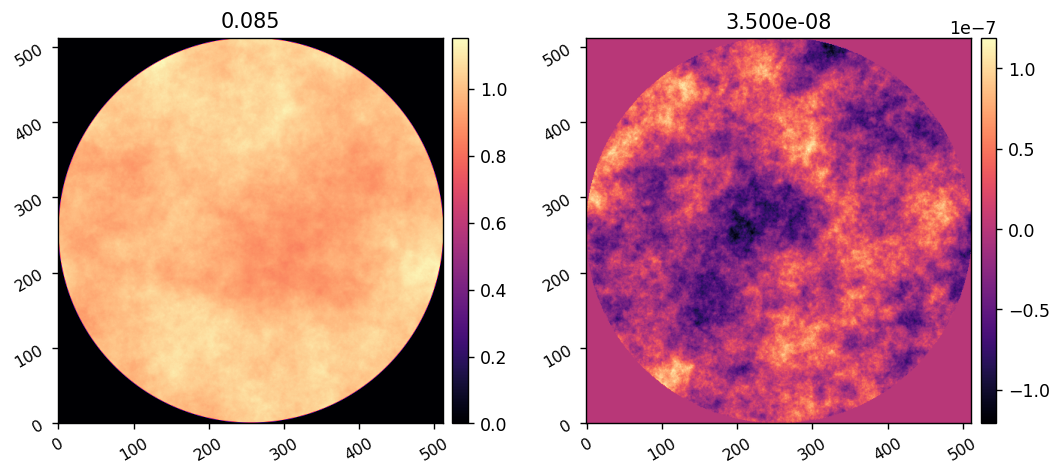

In [77]:
reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')

WFE = APERTURE

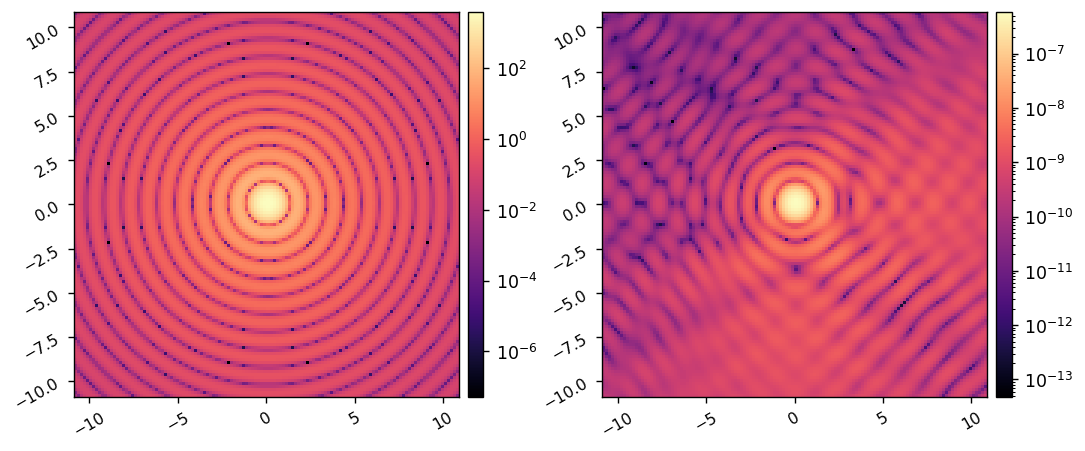

In [78]:
def forward_model(actuators, use_vortex=True):
    command = xp.zeros((Nact,Nact))
    command[dm_mask] = actuators
    mft_command = Mx_dm@command@My_dm
    fourier_surf = fourier_inf_fun * mft_command
    dm_surf = xp.fft.ifft2(fourier_surf).real

    dm_phasor = xp.exp(1j * 4*xp.pi/wavelength.to_value(u.m) * dm_surf)
    wf = utils.pad_or_crop(APERTURE, N).astype(xp.complex128)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)
    wf *= utils.pad_or_crop(dm_phasor, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)
    wf *= utils.pad_or_crop(WFE, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=npix)

    if use_vortex:
        wf = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(wf)))
        wf *= vortex
        wf = xp.fft.fftshift(xp.fft.ifft2(xp.fft.fftshift(wf)))
        # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf *= utils.pad_or_crop(LYOT, N)
    # imshow2(xp.abs(wf), xp.angle(wf), npix=2*npix)

    wf = utils.pad_or_crop(wf, nlyot)
    fpwf = props.mft_forward(wf, psf_pixelscale_lamD, npsf)

    return fpwf

acts = np.zeros(Nacts)
# waffle_command = 10e-9 * xp.ones((Nact,Nact))
# waffle_command[1::2, ::2] *= -1
# waffle_command[::2, 1::2] *= -1
# acts = ensure_np_array(waffle_command[dm_mask]) 

psf_wf = forward_model(acts, use_vortex=False)
coro_wf = forward_model(acts)

psf = xp.abs(psf_wf)**2
coro_im = xp.abs(coro_wf)**2
imshow2(psf, coro_im/xp.max(psf), lognorm=True, pxscl=psf_pixelscale_lamD)


In [60]:
np.ceil(lyot_stop_diam/pupil_diam * npix)

<Quantity 469.>

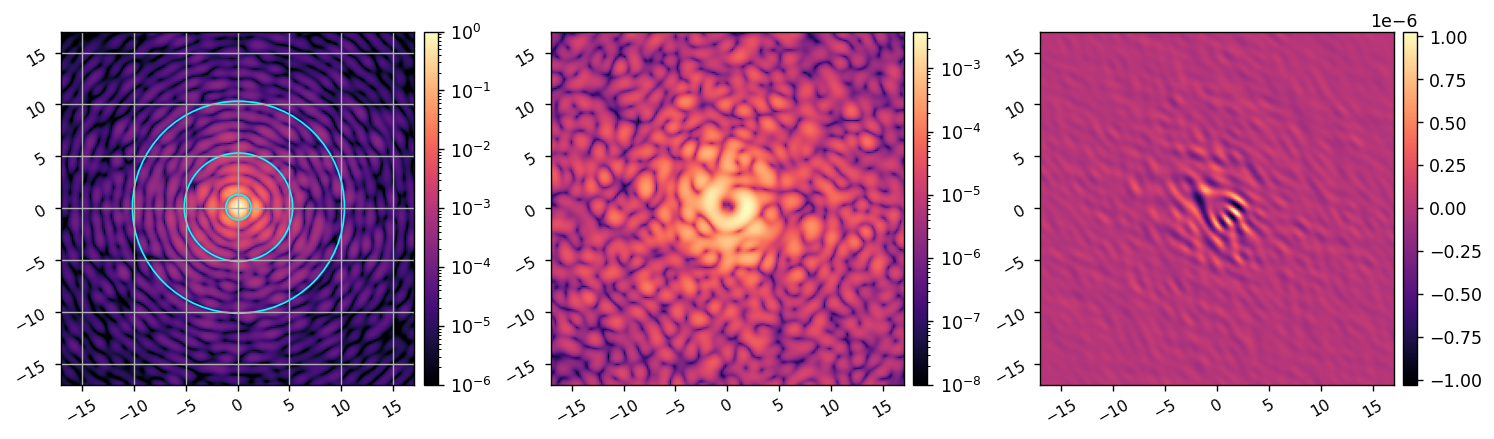

In [3]:
reload(scoob)
model = scoob.CORO()
model.scc_diam = 50*u.um
model.scc_pinhole_position = (scc_sep/np.sqrt(2), scc_sep/np.sqrt(2))

model.WFE = WFE
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True

ref_im = model.snap()

model.use_scc()
scc_im = model.snap()
model.use_scc(False)

imshow3(ref_psf/model.Imax_ref, ref_im, ref_im - scc_im, 
        lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-8,
        pxscl=model.psf_pixelscale_lamD, grid=True, 
        patches1=[Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+4, fill=False, color='cyan'),
                  Circle((model.psf_pixelscale_lamD/2,model.psf_pixelscale_lamD/2), 1.22+9, fill=False, color='cyan')])

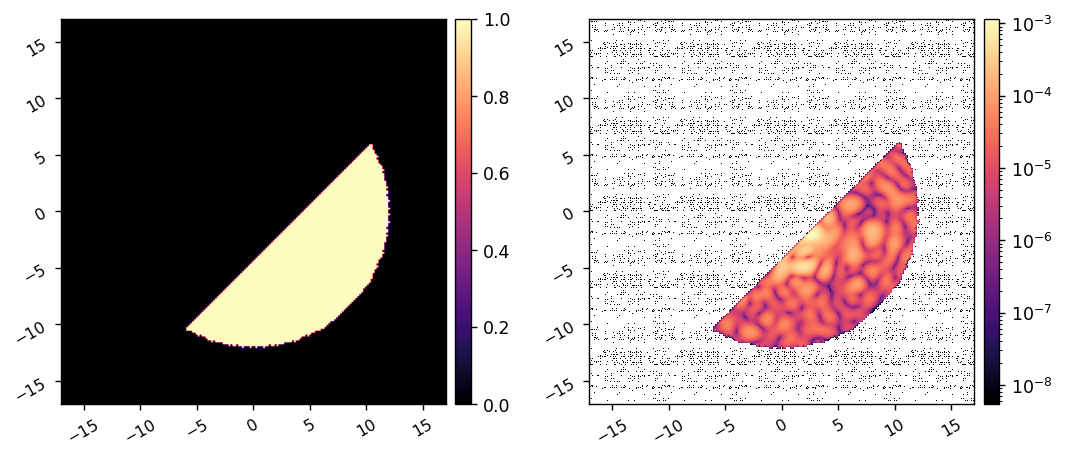

In [4]:
reload(lina.utils)
control_mask = lina.utils.create_annular_focal_plane_mask(model, 3, 12, 3, rotation=45)
imshow2(control_mask, ref_im*control_mask, lognorm2=True, pxscl=model.psf_pixelscale_lamD)


# Create the adjoint model to back propagate 

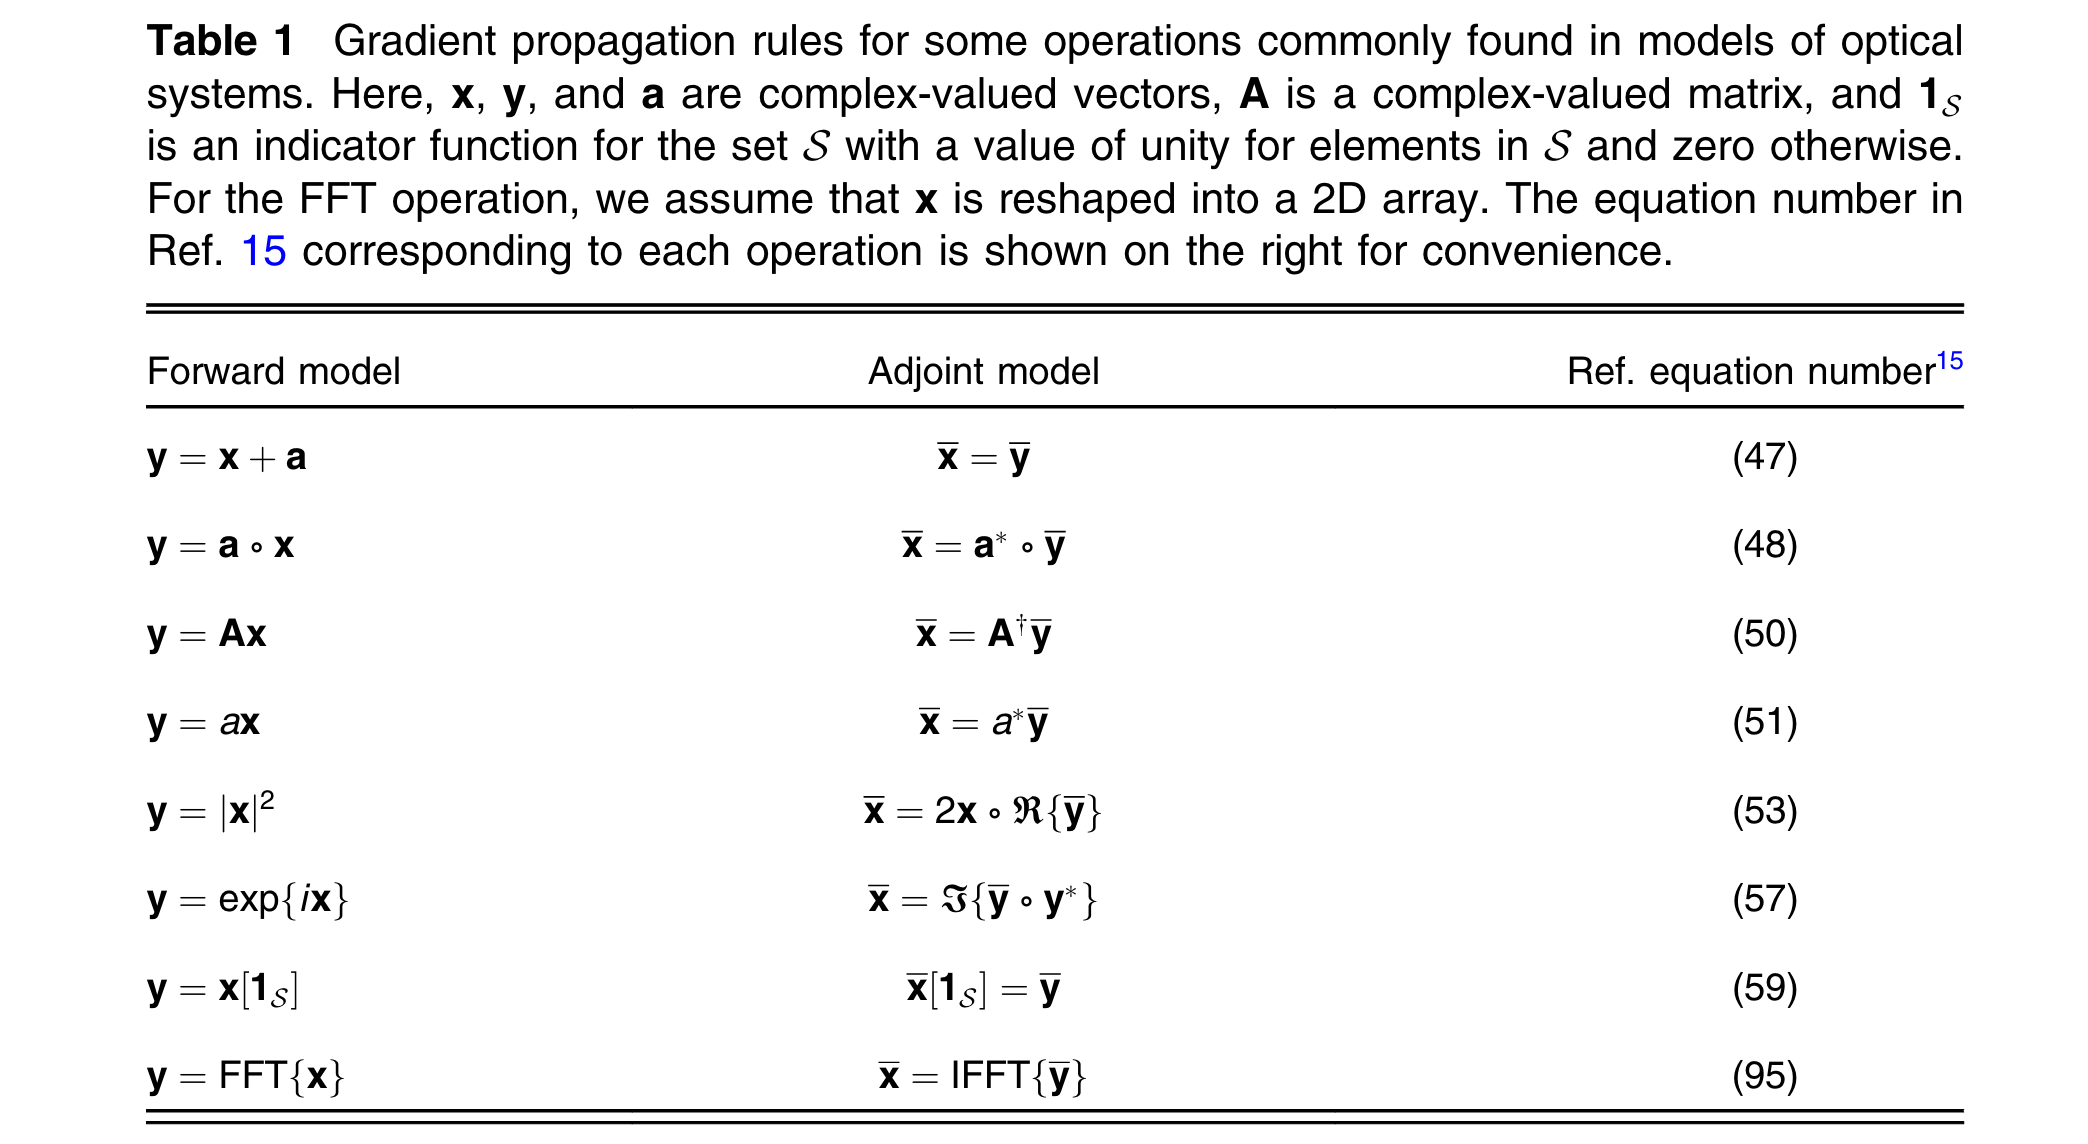